# License Plate Recognition

## 1. Method
The aim of our project is to identify license plate numbers given car images. Our approach to this problem is:
<br>-Localization of license plate on the image
<br>-Segmentation of license plate characters
<br>-Character recognition
 For this purpose, we trained a neural network with images of computer generated characters of different fonts. We use English characters of The Chars74k Dataset which consists of characters A-Z and digits 0-9 from computer fonts with 4 variations (combinations of italic, bold and normal). Below you can see samples from the dataset.

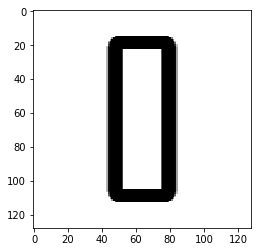

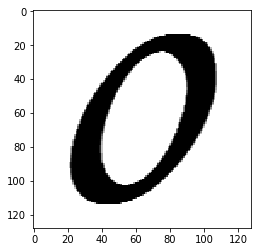

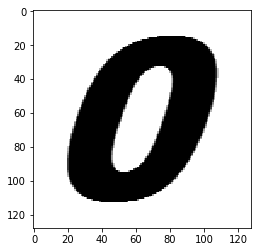

In [17]:
from matplotlib import pyplot as plt
from skimage.io import imread

#fig, (ax1, ax2,ax3) = plt.subplot(1,3,figsize=(8,8))
im=imread('English/Fnt/Sample001/img001-00001.png',as_gray=True)
plt.imshow(im,cmap='gray')
plt.show()
im=imread('English/Fnt/Sample001/img001-00016.png',as_gray=True)
plt.imshow(im,cmap='gray')
plt.show()
im=imread('English/Fnt/Sample001/img001-00036.png',as_gray=True)
plt.imshow(im,cmap='gray')
plt.show()


## 2. Image Processing

First we read an image of a stationary car taken from a cloe distance. 

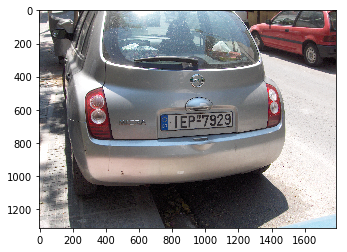

In [38]:
import sys
sys.path.append('/home/muts/anaconda3/envs/environman/lib/python3.5/site-packages')
from skimage.io import imread
from LPDetector import LPDetector

import matplotlib.pyplot as plt

originalImg = imread('car_IEP7929.jpg')

fig, (ax1) = plt.subplots(1, 1)
ax1.imshow(originalImg)
plt.show()

Then we initialize an instance of our licence plate detector object and run it.

In [39]:
licence_plate_detector = LPDetector(originalImg)
# img_list = licence_plate_detector.solve()
# this line will be executed later in the notebook

In [40]:
# Below is the LPDetector class
class LPDetector:
	def __init__(self, _originalImg):
		self.originalImg = _originalImg
	#end constructor
	


	def preprocess(self):
		return myutils.preprocess(self.originalImg)
	#end function



	def locateLicencePlate(self, threshImg):
		height, width = threshImg.shape
		
		label_image = measure.label(threshImg)
		
		plate_dimensions = (0.08*height, 0.2*height, 0.15*width, 0.4*width)
		min_height, max_height, min_width, max_width = plate_dimensions
		plate_like_objects = []

		
		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			fig, (ax1) = plt.subplots(1,figsize=(8,8))
			ax1.imshow(threshImg, cmap="gray");
			ax1.set_title('Possible Licence Plate Regions')			
		# end if         # SHOW STEPS #############  GRAPHICS  #############
		

		# regionprops creates a list of properties of all the labelled regions
		for region in regionprops(label_image):
			if region.area < 50:
				#region is too small then it's probably not a license plate
				continue
			# the bounding box coordinates
			min_row, min_col, max_row, max_col = region.bbox
			region_height = max_row - min_row
			region_width = max_col - min_col
			# dimension check parameters for the plate
			keep_height = region_height >= min_height and region_height <= max_height
			keep_width = region_width >= min_width and region_width <= max_width
			keep_ratio = region_width > region_height
			# ensuring that the region identified satisfies the condition 
			# of a typical license plate
			if keep_height and keep_width and keep_ratio:
				candidate_lp_region = myutils.cropWithBbox(threshImg, region.bbox)
				plate_like_objects.append(candidate_lp_region)
				

				if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
					# draw a red rectangle over those regions
					rectBorder = myutils.bbox2patches(region.bbox)
					ax1.add_patch(rectBorder)
				# end if         # SHOW STEPS #############  GRAPHICS  #############
			#end if
		#end for	
		

		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			plt.show()
		# end if         # SHOW STEPS #############  GRAPHICS  #############
		
		return plate_like_objects		
	# end function locateLicencePlate()



	def extractCharacters(self, plate_like_objects):
		FIND_MIN_CHARACTER = 4
		candidate_char_groups = [] # list of lists of matches.
		
		for plate_candidate in plate_like_objects:
			

			if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
				fig, (ax1) = plt.subplots(1, 1)
				ax1.imshow(plate_candidate, cmap='gray')
				ax1.set_title('Character regions on LP')
			# end if         # SHOW STEPS #############  GRAPHICS  #############


			labels = measure.label(plate_candidate, neighbors=8, background=0)
			matched_char_count = 0
			matched_char_group = []

			for label in np.unique(labels):
				if label == 0: # label is the whole plate 
					continue
				# end if

				# construct the label mask to display only connected components
				# for the current label, then find contours in the label mask
				labelMask = np.zeros(plate_candidate.shape, dtype="uint8")
				labelMask[labels == label] = 255
				cnts = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
				cnts = cnts[1]


				# 1+ contour was found in the mask?
				if len(cnts) > 0:
					c = max(cnts, key=cv2.contourArea)
					possibleChar = PossibleChar(c)
					(boxX, boxY, boxW, boxH) = possibleChar.boundingRect
					# determine if the aspect ratio, solidity, and height of the contour pass
					# the rules tests
					heightRatio = boxH / float(plate_candidate.shape[0])
					ar_good = possibleChar.fltAspectRatio < 1.0
					solidity_good = possibleChar.fltSolidity > 0.15
					hr_good = heightRatio > 0.4 and heightRatio < 0.95


					# if this particular contour looks like a character, we pick it
					if hr_good and solidity_good and ar_good:
						matched_char_count = matched_char_count + 1
						# matched_char = plate_candidate[boxX : boxX+boxH , boxY : boxY+boxW]
						matched_char_region = myutils.cropWithCV2boundingRect(labelMask, possibleChar.boundingRect)
						possibleChar.data = matched_char_region
						matched_char_group.append(possibleChar)
						


						if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
							rectBorder = myutils.cv2br2patches(possibleChar.boundingRect)
							ax1.add_patch(rectBorder)
						# end if          # SHOW STEPS #############  GRAPHICS  #############
					# end if dimension check
				# end if contour length
			# end for label loop

			if matched_char_count >= FIND_MIN_CHARACTER:
				matched_char_group.sort(key = lambda possibleChar: possibleChar.intCenterX)
				candidate_char_groups.append(matched_char_group)
				

				if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
					plt.show()
				# end if          # SHOW STEPS #############  GRAPHICS  #############
			#end if matched char count

			if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
				plt.close(fig)
			# end if          # SHOW STEPS #############  GRAPHICS  #############


		#end for plate candidates
		verdict = []
		# verdict is the character group with longest length  
		if len(candidate_char_groups) > 0:
			verdict = candidate_char_groups[0] 
			max_len = len(candidate_char_groups[0])
			for group in candidate_char_groups:
				if len(group) > max_len:
					max_len = len(group)
					verdict = group

		if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
			for possibleChar in verdict:
				fig, (ax1) = plt.subplots(1,1)
				ax1.imshow(possibleChar.data, cmap='gray')
				plt.show()
			# end for show individual characters
		# end if          # SHOW STEPS #############  GRAPHICS  #############


		return verdict
	#end function extractCharacters



	# turns the images into 120x120 square images
	def resizeVerdict(self, verdict):
		EDGE = 128
		for pc in verdict:
			pix = pc.data
			height, width = pix.shape
			long_edge = max(height, width)
			scale = EDGE / float(long_edge)
			pc.data = cv2.resize(pix, (128, 128))
		#end for
		
		return verdict
	#end function



	def solve(self):
		grayscaleImg, threshImg = self.preprocess()
		

		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			fig, (ax1, ax2) = plt.subplots(1, 2)
			ax1.imshow(grayscaleImg, cmap='gray')
			ax1.set_title('Gray Image')
			ax2.imshow(threshImg, cmap='gray')
			ax2.set_title('Binary Image')
			plt.show()			
		# end if         # SHOW STEPS #############  GRAPHICS  #############


		plate_like_objects = self.locateLicencePlate(threshImg)
		verdict = self.extractCharacters(plate_like_objects)
		verdict = self.resizeVerdict(verdict)

		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			for pc in verdict:
				fig, (ax1) = plt.subplots(1, 1)
				ax1.imshow(pc.data, cmap='gray')
				plt.show()
		# end if         # SHOW STEPS #############  GRAPHICS  #############

		# transform the data to type float range disc[0, 1]
		img_list = [pc.data for pc in verdict]
		floatz = []
		for img in img_list:
			img[img > 127] = 255
			img[img < 128] = 0
			img = img // 255
			img = img.astype(float)
			img = img.flatten()
			floatz.append(img)

		return floatz


### Below is the utility library

In [41]:
import numpy as np
import cv2
# import matplotlib.pyplot as plt
import matplotlib.patches as patches

# turns the image into grayscale
# blurrs it with a square kernel
# uses adaptive thresholding for converting the image to binary
def preprocess(originalImg):
	SMOOTH_KERNEL_SIZE = (5, 5) # kernel
	THRESH_SIZE = 19
	THRESH_WEIGHT = 9
	# gets the value channel instead of grayscale for better accuracy
	def getValueChannel(originalImg):
		height, width, numChannels = originalImg.shape
		# contains hue, saturation, value
		imgHSV = cv2.split(cv2.cvtColor(originalImg, cv2.COLOR_BGR2HSV))          
		return imgHSV[2]

	grayscaleImg = getValueChannel(originalImg)
	height, width = grayscaleImg.shape

	blurredImg = np.zeros((height, width, 1), np.uint8)
	blurredImg = cv2.GaussianBlur(grayscaleImg, SMOOTH_KERNEL_SIZE, 0)
	threshImg = cv2.adaptiveThreshold(blurredImg, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, THRESH_SIZE, THRESH_WEIGHT)

	return grayscaleImg, threshImg

# crops the given NxM numpy array wrt border box
def cropWithBbox(threshImg, bbox):
    min_row, min_col, max_row, max_col = bbox
    return threshImg[min_row:max_row, min_col:max_col]


# basically type casts a bbox into a patches.Rectangle objcect
def bbox2patches(bbox):
    min_row, min_col, max_row, max_col = bbox
    x, y = min_row, min_col
    w, h = max_col - y, max_row - x
    return   patches.Rectangle((y, x), w, h, edgecolor="red", linewidth=2, fill=False)

# basicaly type casts a cv2.boundingRectangle to patches.Rectangle
def cv2br2patches(cv2bRect):
	(X, Y, W, H) = cv2bRect
	return patches.Rectangle((X, Y), W, H, edgecolor="red", linewidth=2, fill=False)



# crops the given NxM numpy array wrt a cv2.boundingRectangle object
def cropWithCV2boundingRect(binaryImg, cv2bRect):
	(boxX, boxY, boxW, boxH) = cv2bRect
	min_col, min_row = boxX, boxY
	max_col, max_row = min_col + boxW, min_row + boxH
	return binaryImg[min_row:max_row, min_col:max_col]


Below is a little class to help manage character-like regions.

In [48]:
import cv2
import numpy as np
import math
import myutils

class PossibleChar:

    def __init__(self, _contour):
        self.contour = _contour

        self.boundingRect = cv2.boundingRect(self.contour)
        [intX, intY, intWidth, intHeight] = self.boundingRect

        self.intX = intX
        self.intY = intY
        self.intW = intWidth
        self.intH = intHeight

        self.intArea = self.intW * self.intH

        self.intCenterX = (self.intX + self.intX + self.intW) / 2
        self.intCenterY = (self.intY + self.intY + self.intH) / 2

        self.fltAspectRatio = float(self.intW) / float(self.intH)
        self.fltSolidity = cv2.contourArea(self.contour) / float(self.intArea)

### Execution of LPDetector class' solve method line by line. Which is called in the main script.

Below is the preprocessing step. Where the image is represented with HSV color space, then the value channel is extracted. Since the grayscale conversion of an image is basically a weighted sum of its RGB channels, we chose to use value channel(who is a dedicated dimension to brightness) over grayscale conversion. It empirically proved to be more succesful when performing threshold operations to extract the character regions. Then the image is blurred using 5x5 gaussian smoothing kernel. Otsu's threshold method is utilized for thresholding, which was  later changed to adaptive threshold. This way we obtained less bulky characters and lines. Hence obtained better recognition 

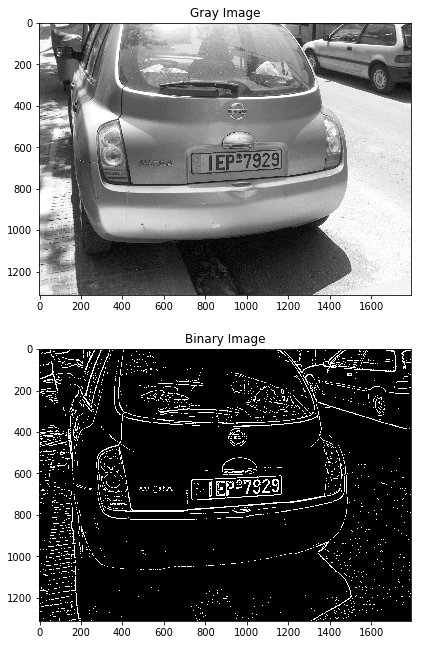

In [42]:
grayscaleImg, threshImg = licence_plate_detector.preprocess()
if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 11))
			ax1.imshow(grayscaleImg, cmap='gray')
			ax1.set_title('Gray Image')
			ax2.imshow(threshImg, cmap='gray')
			ax2.set_title('Binary Image')
			plt.show()			
		# end if         # SHOW STEPS #############  GRAPHICS  #############


# The function that is called is below:

# # turns the image into grayscale
# # blurrs it with a square kernel
# # uses adaptive thresholding for converting the image to binary
# def preprocess(originalImg):
# 	SMOOTH_KERNEL_SIZE = (5, 5) # kernel
# 	THRESH_SIZE = 19
# 	THRESH_WEIGHT = 9
# 	# gets the value channel instead of grayscale for better accuracy
# 	def getValueChannel(originalImg):
# 		height, width, numChannels = originalImg.shape
# 		# contains hue, saturation, value
# 		imgHSV = cv2.split(cv2.cvtColor(originalImg, cv2.COLOR_BGR2HSV))          
# 		return imgHSV[2]

# 	grayscaleImg = getValueChannel(originalImg)
# 	height, width = grayscaleImg.shape

# 	blurredImg = np.zeros((height, width, 1), np.uint8)
# 	blurredImg = cv2.GaussianBlur(grayscaleImg, SMOOTH_KERNEL_SIZE, 0)
# 	threshImg = cv2.adaptiveThreshold(blurredImg, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, THRESH_SIZE, THRESH_WEIGHT)

# 	return grayscaleImg, threshImg


At this point we have a binary treshold image of the original one. Now we need to look for plate-like objects. In order to locate plate-like objects, connected component analysis is utilized. Just to get an idea about the number of connected components: a 768*1024 image roughly yields a couple of thousands of connected regions. This step is mostly about elimnating those regions. First the regions are filtered according to their areas. And then by their height and width values. It is assumed that 

a _**plateregion's width / image's width**_ should be between 0.15 and 0.4

and

a _**plateregion's height / image's height**_ should be between 0.08 and 0.2

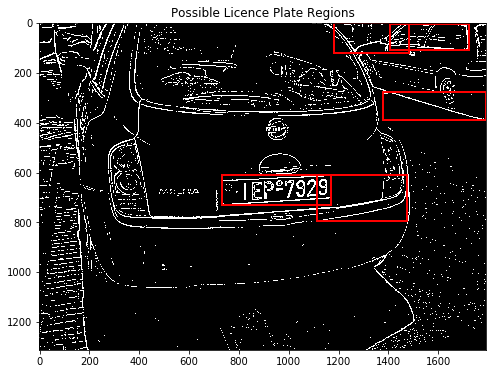

In [43]:
plate_like_objects = licence_plate_detector.locateLicencePlate(threshImg)

#### The function that is called is below: ####


# def locateLicencePlate(self, threshImg):
# 		height, width = threshImg.shape
		
# 		label_image = measure.label(threshImg)
		
# 		plate_dimensions = (0.08*height, 0.2*height, 0.15*width, 0.4*width)
# 		min_height, max_height, min_width, max_width = plate_dimensions
# 		plate_like_objects = []

		
# 		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
# 			fig, (ax1) = plt.subplots(1,figsize=(8,8))
# 			ax1.imshow(threshImg, cmap="gray");
# 			ax1.set_title('Possible Licence Plate Regions')			
# 		# end if         # SHOW STEPS #############  GRAPHICS  #############
		

# 		# regionprops creates a list of properties of all the labelled regions
# 		for region in regionprops(label_image):
# 			if region.area < 50:
# 				#region is too small then it's probably not a license plate
# 				continue
# 			# the bounding box coordinates
# 			min_row, min_col, max_row, max_col = region.bbox
# 			region_height = max_row - min_row
# 			region_width = max_col - min_col
# 			# dimension check parameters for the plate
# 			keep_height = region_height >= min_height and region_height <= max_height
# 			keep_width = region_width >= min_width and region_width <= max_width
# 			keep_ratio = region_width > region_height
# 			# ensuring that the region identified satisfies the condition 
# 			# of a typical license plate
# 			if keep_height and keep_width and keep_ratio:
# 				candidate_lp_region = myutils.cropWithBbox(threshImg, region.bbox)
# 				plate_like_objects.append(candidate_lp_region)
				

# 				if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
# 					# draw a red rectangle over those regions
# 					rectBorder = myutils.bbox2patches(region.bbox)
# 					ax1.add_patch(rectBorder)
# 				# end if         # SHOW STEPS #############  GRAPHICS  #############
# 			#end if
# 		#end for	
		

# 		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
# 			plt.show()
# 		# end if         # SHOW STEPS #############  GRAPHICS  #############
		
# 		return plate_like_objects		
# 	# end function locateLicencePlate()

In [44]:
len(plate_like_objects)

5

At this point, the programmed filtered out every region but those 5. In the next section we will try to determine which of these regions most likely contains the licence plate.


In layman's terms, we do this by observing each region and trying to extract **_character like regions_** from each region. The region that has most **_character like regions_** is then selected as the plate region.

We label a plate candidate and then mask it so that only the connected components for the current label is displayed. Then we find contours in the label mask. A contour's bounding rectangle makes **_character like region_** if and only if the rectangle's and the plate candidate's height ratio is between 0.4 and 0.95, the contours solidity is greater than 15 percent, and its aspect ratio is less than 1(since most letters are rather long and thin).

If we are able to find at least 4 character-like region in a plate candidate, we mark that as a plate. Then sort the aforementioned character-like regions with respect to their center's X coordinates.

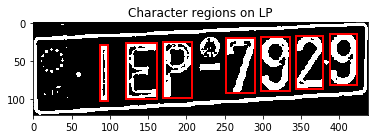

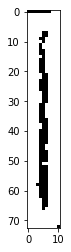

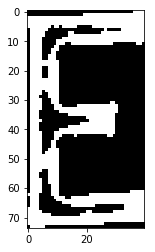

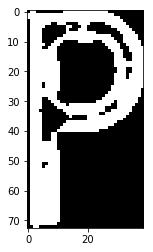

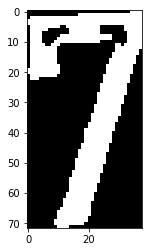

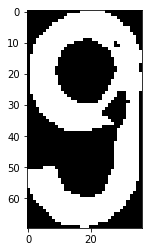

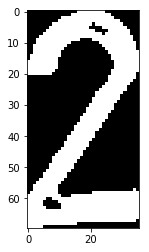

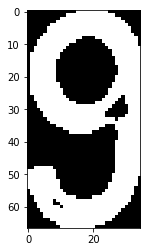

In [45]:
verdict = licence_plate_detector.extractCharacters(plate_like_objects)

# Code being executed is not put below since it was too long. 
# It is contained in the notebook in LPDetector.py section.




In case of marking more than one plate candidate as _plate_, we break the ties by picking the region that has the most character-like regions. And then crop those regions as numpy.ndarrays.

### Sending input for optical character recognition 

At this point, we have a verdict, a list of `possible character` objects. Now it is time we feed them to our character recognition neural network. The network takes 128x128 binary images as input. Hence we need some tweaking to do.

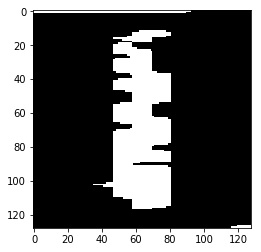

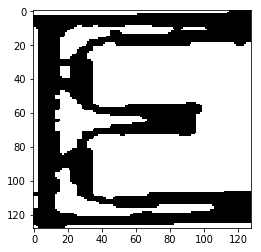

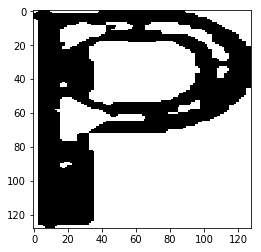

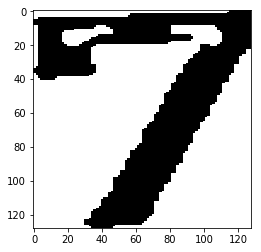

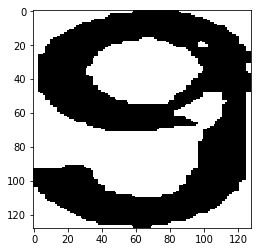

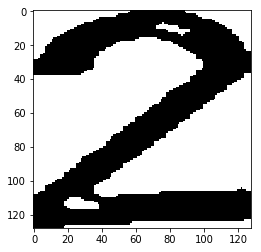

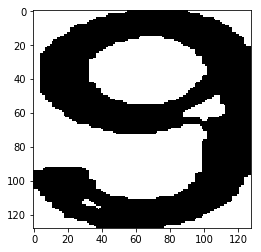

In [46]:
verdict = licence_plate_detector.resizeVerdict(verdict)

# transform the data to type float range disc[0, 1]
img_list = [pc.data for pc in verdict]
floatz = []
for img in img_list:
    img[img > 127] = 255
    img[img < 128] = 0
    img = 255 - img
    fix, (ax1) = plt.subplots(1, 1)
    ax1.imshow(img, cmap='gray')
    plt.show()
    img = img // 255
    img = img.astype(float)
    img = img.flatten()
    floatz.append(img)

The neural net takes images as rows of size 128x128 of type float. So that is what we did here. First we resized the images to 128x128, then we converted them to float and flattened them. At this point the `floatz` variable can be fed to the classifier.

## 3. Training the NN
 For the optical character recognition part 2 layer neural network is trained using Pytorch framework on the Chars74K dataset[1], total of 32400 images of characters from computer fonts with 4 variations (combinations of italic, bold and normal) These are digits from 0-9 and letters from A-Z. Our model is tested on 3600 images of the same format.
 <br>**Input layer**: expects an array of length 16384(input layer node number) binary numbers
 <br>**Hidden layer**:250 node, ReLu activation function
 <br>**Output layer**: 36 node, logsoftmax activation function
 
 Output of the network is an array consisting of log probability classes. We assign classes according to argmax of output.
 
 The functional form of the neural network:
    $$ f(x; W, b )=LogSoftmax(W_2 ReLu(W_1x + b_1) + b_2)$$ 
    <br>where ReLu is a rectified linear unit which is an activation function defined as the positive part of its argument. W and b represent weight and bias vectors, respectively. Input 'x' is the matrix each row of which represents pixel values of detected characters from the license plate.
     
Loss function that we try to minimize:
$$L(\theta;x)=\sum_{i}{f(x_i|\theta)}$$
where $\theta$ represents the parameter vector.
    
For the optimization part, 'Adam Algorithm' implemented on Pytorch is used. Adam is different to classical stochastic gradient descent. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training. A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

### Experiment

We conduct our experiments based on below mentioned hyperparameters.
<br>1. Number of hidden layer node: [250:50:500]
<br>2.Number of epoch [500:300:2000]
<br>3.Minibatch size:[300:100:800]
<br>4.Learning rate:[0.001,0.0001,0.00001]
<br>The best model we can obtain is as follows:

In [ ]:
import numpy as np
from skimage import io as io
import torch
import random
import seaborn

loc = "D:/Downloads/English/Fnt/"
N , D_in , H , D_out = 36*1000 , 128*128 , 250 , 36

# Read Data and Save
# Randomly choose for train and test
x_train = np.zeros( (36*900 , D_in ), dtype = np.float)
y_train = np.zeros( 36*900 , dtype = np.long)
x_test = np.zeros( (36*100 , D_in) , dtype = np.float)
y_test = np.zeros( 36*100 , dtype = np.long)
k = 0
l = 0
for i in range(1 , 37):
    r = random.sample(range(1,1001) ,100)
    for  j in range(1 ,1001):
        img = io.imread(loc + "Sample" + str(i).zfill(3) + "/img" + str(i).zfill(3) + "-" + str(j).zfill(5) + ".png" , as_gray = True)
        img = img.flatten()
        img = list(map(lambda x: 1.0 if x>127 else 0.0 , img ))
        if j in r:
            x_test[k , : ] = np.array(img)
            y_test[k] = i-1
            k = k + 1
        else:
            y_train[l] = i-1
            x_train[l , : ] = np.array(img) 
            l = l + 1

np.save('xtrain' , x_train)
np.save('xtest' , x_test)
np.save('ytrain' , y_train)
np.save('ytest' , y_test)



# Load train data and train the NN
x_train = np.load('xtrain.npy')
y_train = np.load('ytrain.npy')
index = np.random.permutation(36*900)
x_train = torch.from_numpy(x_train[index , :])
y_train = torch.from_numpy(y_train[index])

model = torch.nn.Sequential(
    torch.nn.Linear(D_in , H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.LogSoftmax(),
)

model = model.double()
loss_fn = torch.nn.NLLLoss(size_average=False)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(2000):
    index =random.sample(range(0,36*900) , 500)
    loss = loss_fn(model(x_train[index , : ]) , y_train[index].type(torch.LongTensor))
    print( i , loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
torch.save(model , 'model.pt')




# Load model and test
x_test = np.load('xtest.npy')
y_test = np.load('ytest.npy')
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
conf=np.zeros((36,36),dtype=np.int32)
model = torch.load('model.pt')
with torch.no_grad():
    y_pred = model(x_test)
    k = 0
    for i in range(0,len(y_test)):
        conf[y_test[i] , torch.argmax(y_pred[i , :] ).type(torch.int32)] = conf[y_test[i] , torch.argmax(y_pred[i , :] ).type(torch.int32)] + 1
        if torch.argmax(y_pred[i , :] ).type(torch.int32) - y_test[i] != 0:
            k = k+1
    print(k , len(y_test))
    
seaborn.heatmap(conf)
plt.xlabel('predicted classes')
plt.ylabel('actual classes')
plt.show()    

## Results

Heatmap below shows the confusion matrix result on synthetic test data with our model. Indices from 0-9 represent the digits and from 10-36 represent the letters A-Z. The network lacks differentiating between similar characters such as 0 and O, 1 and I etc.

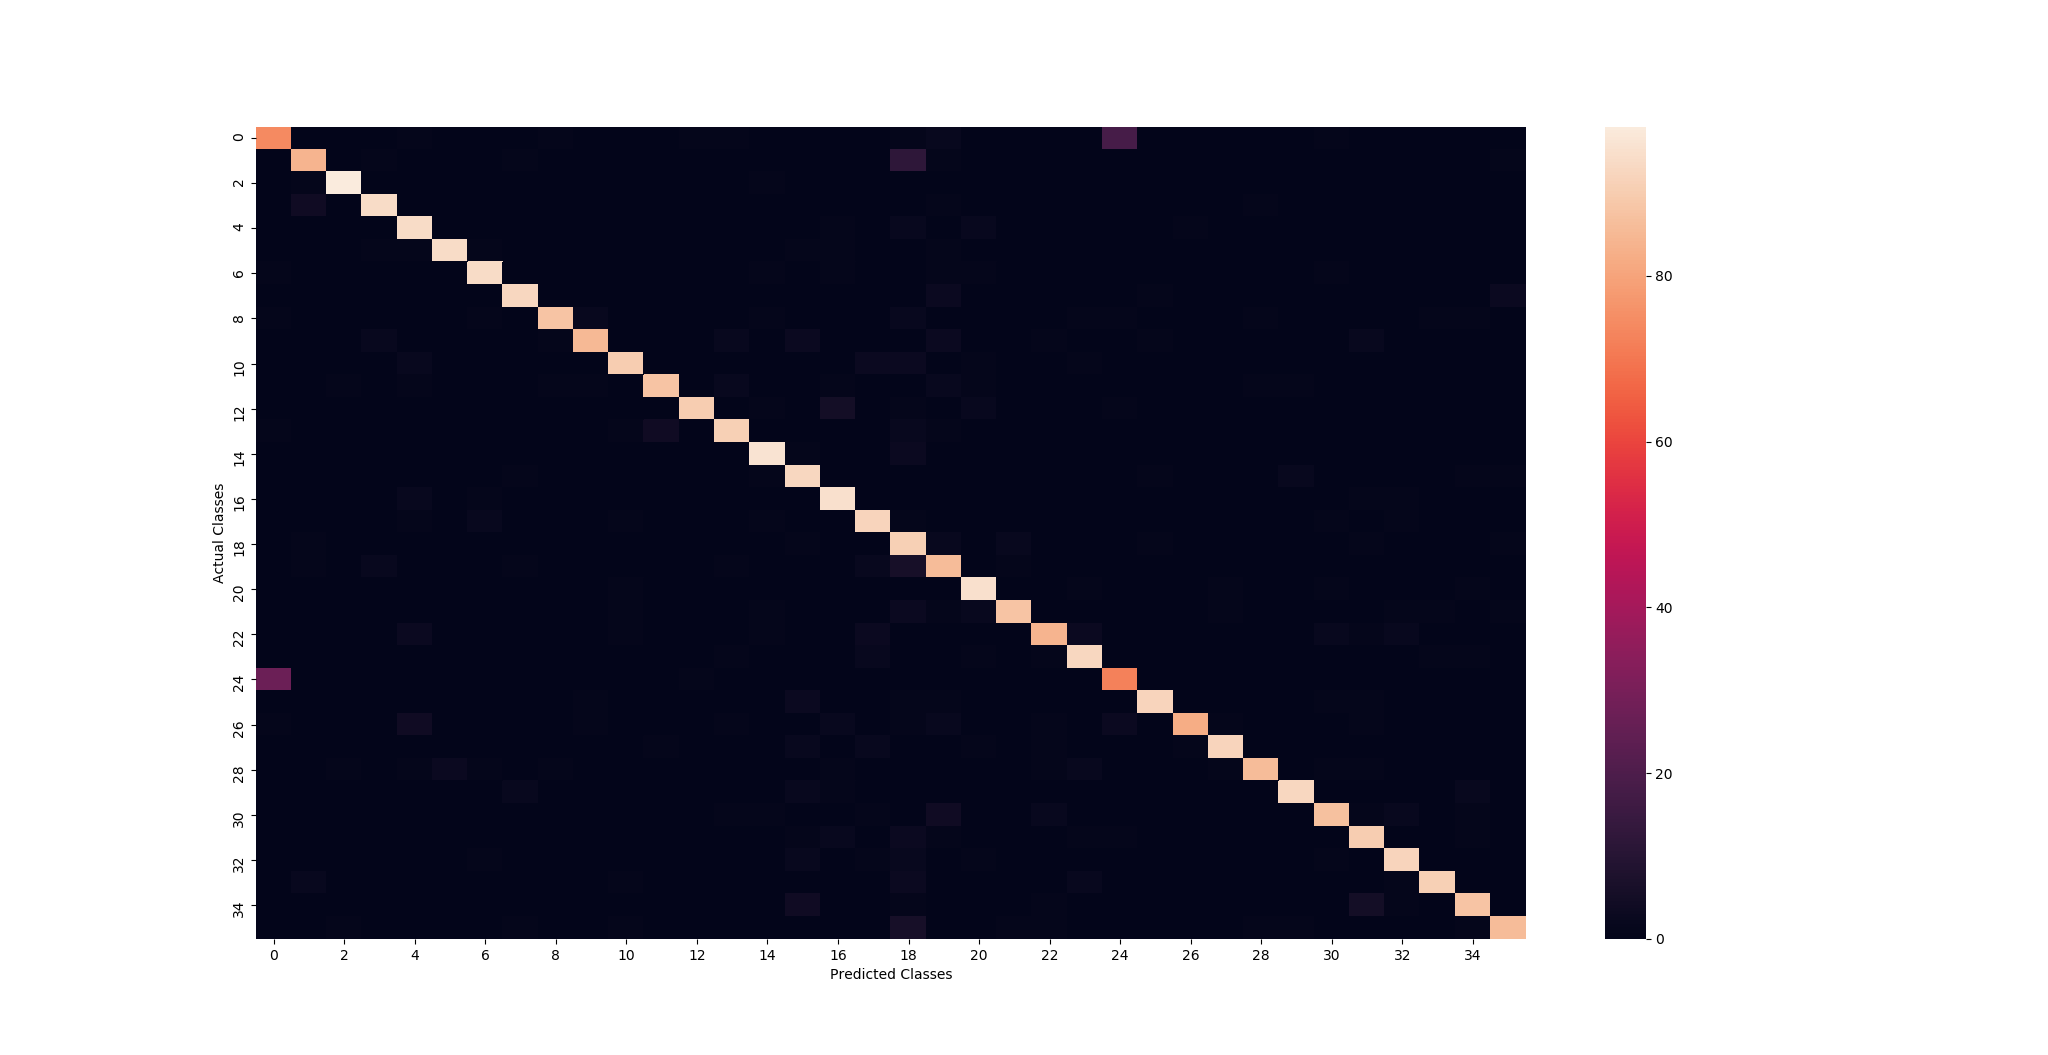

In [3]:
from IPython.display import Image
Image("Figure_1.png")

Test result on random characters : 379 wrong on 3600 testcases(%10.52).

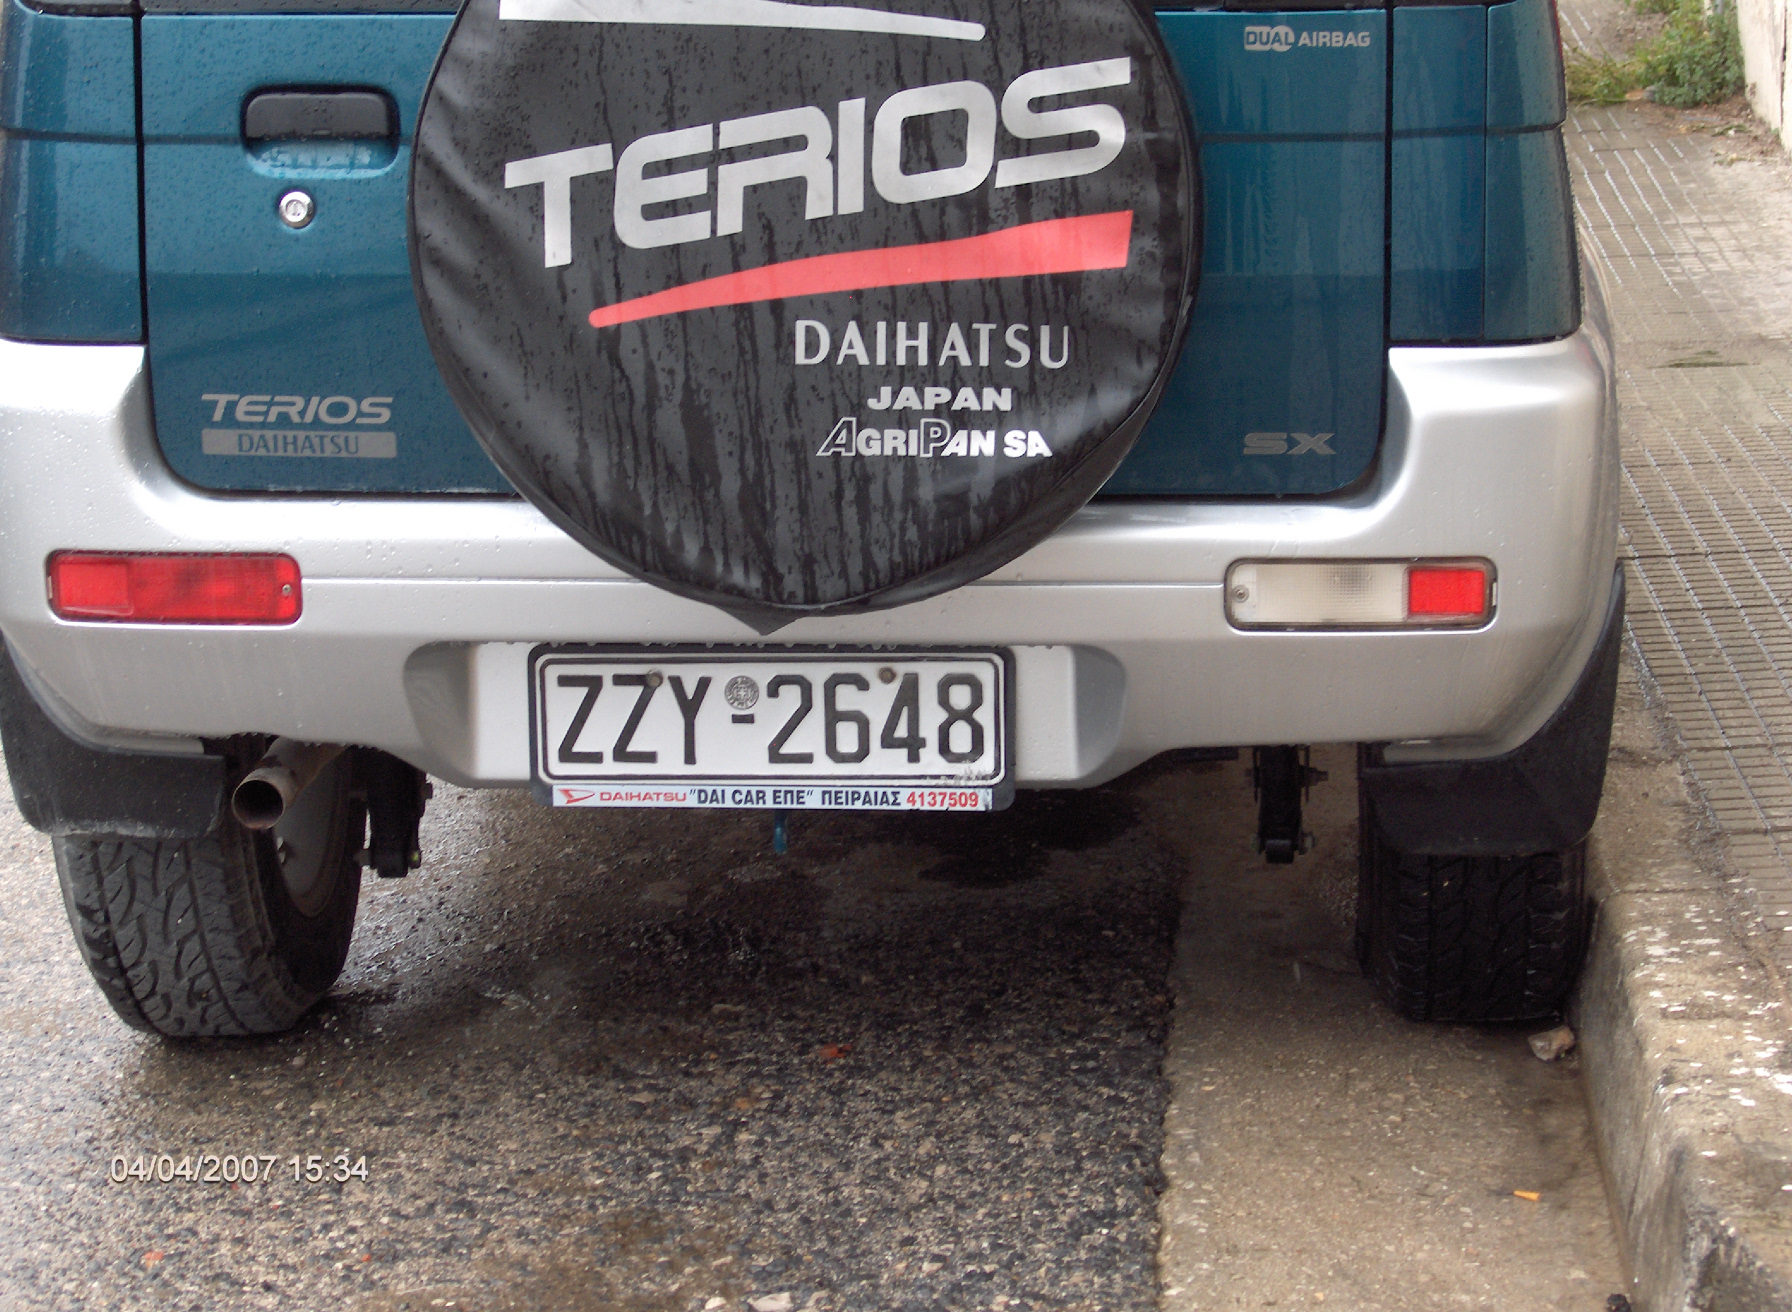

In [10]:
Image("HPIM0686.JPG")

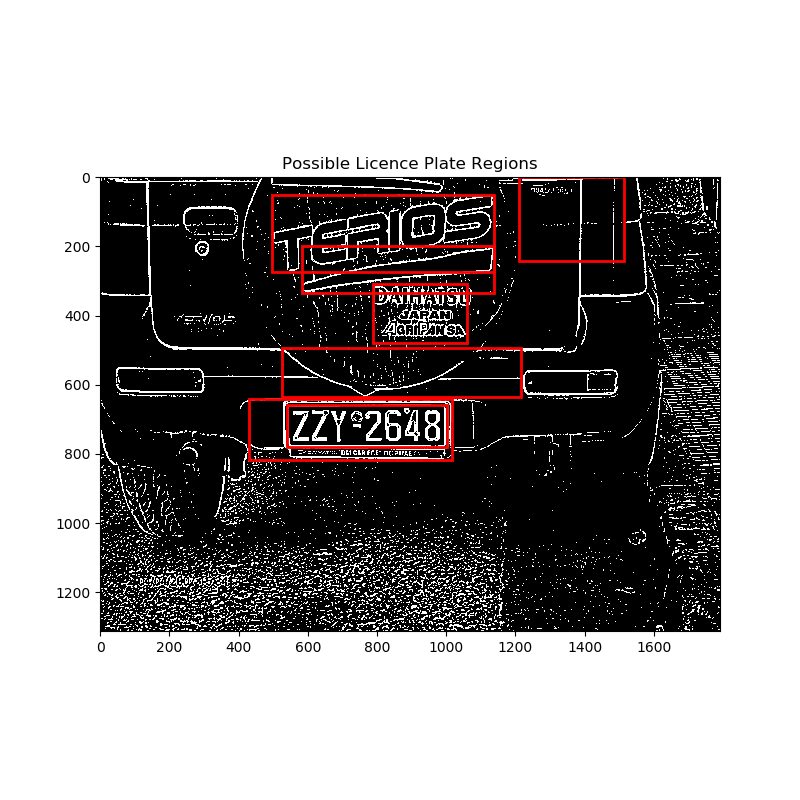

In [11]:
Image("Figure_2.png")

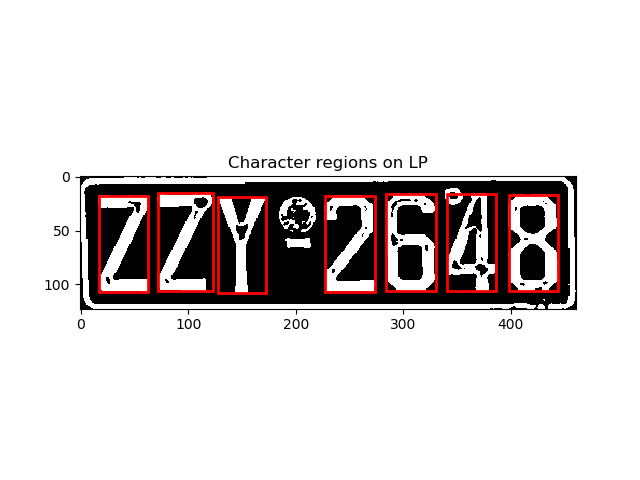

In [12]:
Image("Figure_3.png")

Z7YJ60H (it is common for our tests that 0 and 4, 7 and J are confusing)

## Conclusion

Our model did'n give accurate results on plates but test data which is %90 accurate. Main reason for this problem is we can't find properly labeled data set for plates, so we use computer generated numbers and characters. This causes our model accurate only perfect images. For example when we get numbers from a plate, it has a noise and empty pixels on numbers. 
Also we can use spesific properties of the plates, we use same country's plates, like fist half consists of letters and second half consists of numbers. This give more accurate results. Also we have two NN for this purpose. We should implement better pre procesing tool for plate images

## Improvements
We implement new algorithm to detect plates and their characters.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from collections import namedtuple

from skimage.filters import threshold_local
from skimage import segmentation, measure
from skimage import measure
from skimage.measure import regionprops
from skimage.io import imread

import numpy as np
import cv2

import myutils
from PossibleChar import PossibleChar 

SHOW_STEPS = True

class LPDetector:
	def __init__(self, _originalImg):
		self.originalImg = _originalImg
	#end constructor
	


	def preprocess(self):
		return myutils.preprocess(self.originalImg)
	#end function



	def locateLicencePlate(self, threshImg, grayscaleImg):
		height, width = threshImg.shape
		
		label_image = measure.label(threshImg)
		
		plate_dimensions = (0.08*height, 0.2*height, 0.15*width, 0.4*width)
		min_height, max_height, min_width, max_width = plate_dimensions
		plate_like_objects = []
		plate_like_objects_gray = []

		
		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			fig, (ax1) = plt.subplots(1,figsize=(8,8))
			ax1.imshow(threshImg, cmap="gray");
			ax1.set_title('Possible Licence Plate Regions')			
		# end if         # SHOW STEPS #############  GRAPHICS  #############
		

		# regionprops creates a list of properties of all the labelled regions
		for region in regionprops(label_image):
			if region.area < 50:
				#region is too small then it's probably not a license plate
				continue
			# the bounding box coordinates
			min_row, min_col, max_row, max_col = region.bbox
			region_height = max_row - min_row
			region_width = max_col - min_col
			# dimension check parameters for the plate
			keep_height = region_height >= min_height and region_height <= max_height
			keep_width = region_width >= min_width and region_width <= max_width
			keep_ratio = region_width > region_height
			# ensuring that the region identified satisfies the condition 
			# of a typical license plate
			if keep_height and keep_width and keep_ratio:
				candidate_lp_region = myutils.cropWithBbox(threshImg, region.bbox)
				candidate_lp_region_gray = myutils.cropWithBbox(grayscaleImg, region.bbox)
				plate_like_objects.append(candidate_lp_region)
				plate_like_objects_gray.append(candidate_lp_region_gray)
				

				if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
					# draw a red rectangle over those regions
					rectBorder = myutils.bbox2patches(region.bbox)
					ax1.add_patch(rectBorder)
				# end if         # SHOW STEPS #############  GRAPHICS  #############
			#end if
		#end for	
		

		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			plt.show()
		# end if         # SHOW STEPS #############  GRAPHICS  #############
		
		return plate_like_objects, plate_like_objects_gray
	# end function locateLicencePlate()



	def extractCharacters(self, plate_like_objects, plate_like_objects_gray):
		FIND_MIN_CHARACTER = 4
		candidate_char_groups = [] # list of lists of matches.
		
		for plate_candidate, plate_candidate_gray in zip(plate_like_objects, plate_like_objects_gray):
			

			if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
				fig, (ax1) = plt.subplots(1, 1)
				ax1.imshow(plate_candidate, cmap='gray')
				ax1.set_title('Character regions on LP')
			# end if         # SHOW STEPS #############  GRAPHICS  #############


			labels = measure.label(plate_candidate, neighbors=8, background=0)
			matched_char_count = 0
			matched_char_group = []

			for label in np.unique(labels):
				if label == 0: # label is the whole plate 
					continue
				# end if

				# construct the label mask to display only connected components
				# for the current label, then find contours in the label mask
				labelMask = np.zeros(plate_candidate.shape, dtype="uint8")
				labelMask[labels == label] = 255
				cnts = cv2.findContours(labelMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
				cnts = cnts[1]


				# 1+ contour was found in the mask?
				if len(cnts) > 0:
					c = max(cnts, key=cv2.contourArea)
					possibleChar = PossibleChar(c)
					(boxX, boxY, boxW, boxH) = possibleChar.boundingRect
					# determine if the aspect ratio, solidity, and height of the contour pass
					# the rules tests
					heightRatio = boxH / float(plate_candidate.shape[0])
					ar_good = possibleChar.fltAspectRatio < 1.0
					solidity_good = possibleChar.fltSolidity > 0.15
					hr_good = heightRatio > 0.4 and heightRatio < 0.95


					# if this particular contour looks like a character, we pick it
					if hr_good and solidity_good and ar_good:
						matched_char_count = matched_char_count + 1
						# matched_char = plate_candidate[boxX : boxX+boxH , boxY : boxY+boxW]
						matched_char_region = myutils.cropWithCV2boundingRect(plate_candidate_gray, possibleChar.boundingRect)
						platemean = matched_char_region.mean()
						matched_char_region[matched_char_region<platemean] = 0
						matched_char_region[matched_char_region>=platemean] = 255
						matched_char_region = 255 - matched_char_region
						possibleChar.data = matched_char_region
						matched_char_group.append(possibleChar)
						


						if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
							rectBorder = myutils.cv2br2patches(possibleChar.boundingRect)
							ax1.add_patch(rectBorder)
						# end if          # SHOW STEPS #############  GRAPHICS  #############
					# end if dimension check
				# end if contour length
			# end for label loop

			if matched_char_count >= FIND_MIN_CHARACTER:
				matched_char_group.sort(key = lambda possibleChar: possibleChar.intCenterX)
				candidate_char_groups.append(matched_char_group)
				

				if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
					plt.show()
				# end if          # SHOW STEPS #############  GRAPHICS  #############
			#end if matched char count

			if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
				plt.close(fig)
			# end if          # SHOW STEPS #############  GRAPHICS  #############


		#end for plate candidates
		verdict = []
		# verdict is the character group with longest length  
		if len(candidate_char_groups) > 0:
			verdict = candidate_char_groups[0] 
			max_len = len(candidate_char_groups[0])
			for group in candidate_char_groups:
				if len(group) > max_len:
					max_len = len(group)
					verdict = group

		if SHOW_STEPS:    # SHOW STEPS #############  GRAPHICS  #############
			for possibleChar in verdict:
				fig, (ax1) = plt.subplots(1,1)
				ax1.imshow(possibleChar.data, cmap='gray')
				plt.show()
			# end for show individual characters
		# end if          # SHOW STEPS #############  GRAPHICS  #############


		return verdict
	#end function extractCharacters



	# turns the images into 120x120 square images
	def resizeVerdict(self, verdict):
		EDGE = 128
		THRSHL = 104
		for pc in verdict:
			newData = np.zeros((128, 128), dtype='uint8')
			pix = pc.data
			height, width = pix.shape



			print(height, width)
			if height < THRSHL:
				scale = THRSHL/ float(height)
				pix = cv2.resize(pix, (int(scale*width), THRSHL))
			height, width = pix.shape

			start_row = (128 - height) // 2
			end_row = start_row + height
			start_col = (128 - width) // 2
			end_col = start_col + width
			newData[start_row:end_row, start_col:end_col] = pix
			
			pc.data = newData
			print('BASIYORUZ')
			fig, (ax1) = plt.subplots(1, 1)
			ax1.imshow(pix, cmap='gray')
			plt.show()

		#end for
		
		return verdict
	#end function



	def solve(self):
		grayscaleImg, threshImg = self.preprocess()
		

		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			fig, (ax1, ax2) = plt.subplots(1, 2)
			ax1.imshow(grayscaleImg, cmap='gray')
			ax1.set_title('Gray Image')
			ax2.imshow(threshImg, cmap='gray')
			ax2.set_title('Binary Image')
			plt.show()			
		# end if         # SHOW STEPS #############  GRAPHICS  #############


		plate_like_objects, plate_like_objects_gray = self.locateLicencePlate(threshImg, grayscaleImg)
		verdict = self.extractCharacters(plate_like_objects, plate_like_objects_gray)
		verdict = self.resizeVerdict(verdict)

		if SHOW_STEPS:   # SHOW STEPS #############  GRAPHICS  #############
			for pc in verdict:
				fig, (ax1) = plt.subplots(1, 1)
				ax1.imshow(pc.data, cmap='gray')
				plt.show()
		# end if         # SHOW STEPS #############  GRAPHICS  #############

		# transform the data to type float range disc[0, 1]
		img_list = [pc.data for pc in verdict]
		floatz = []
		for img in img_list:
			img[img > 127] = 255
			img[img < 128] = 0
			img = 255 - img
			img = img // 255
			img = img.astype(float)
			img = img.flatten()
			floatz.append(img)

		return floatz


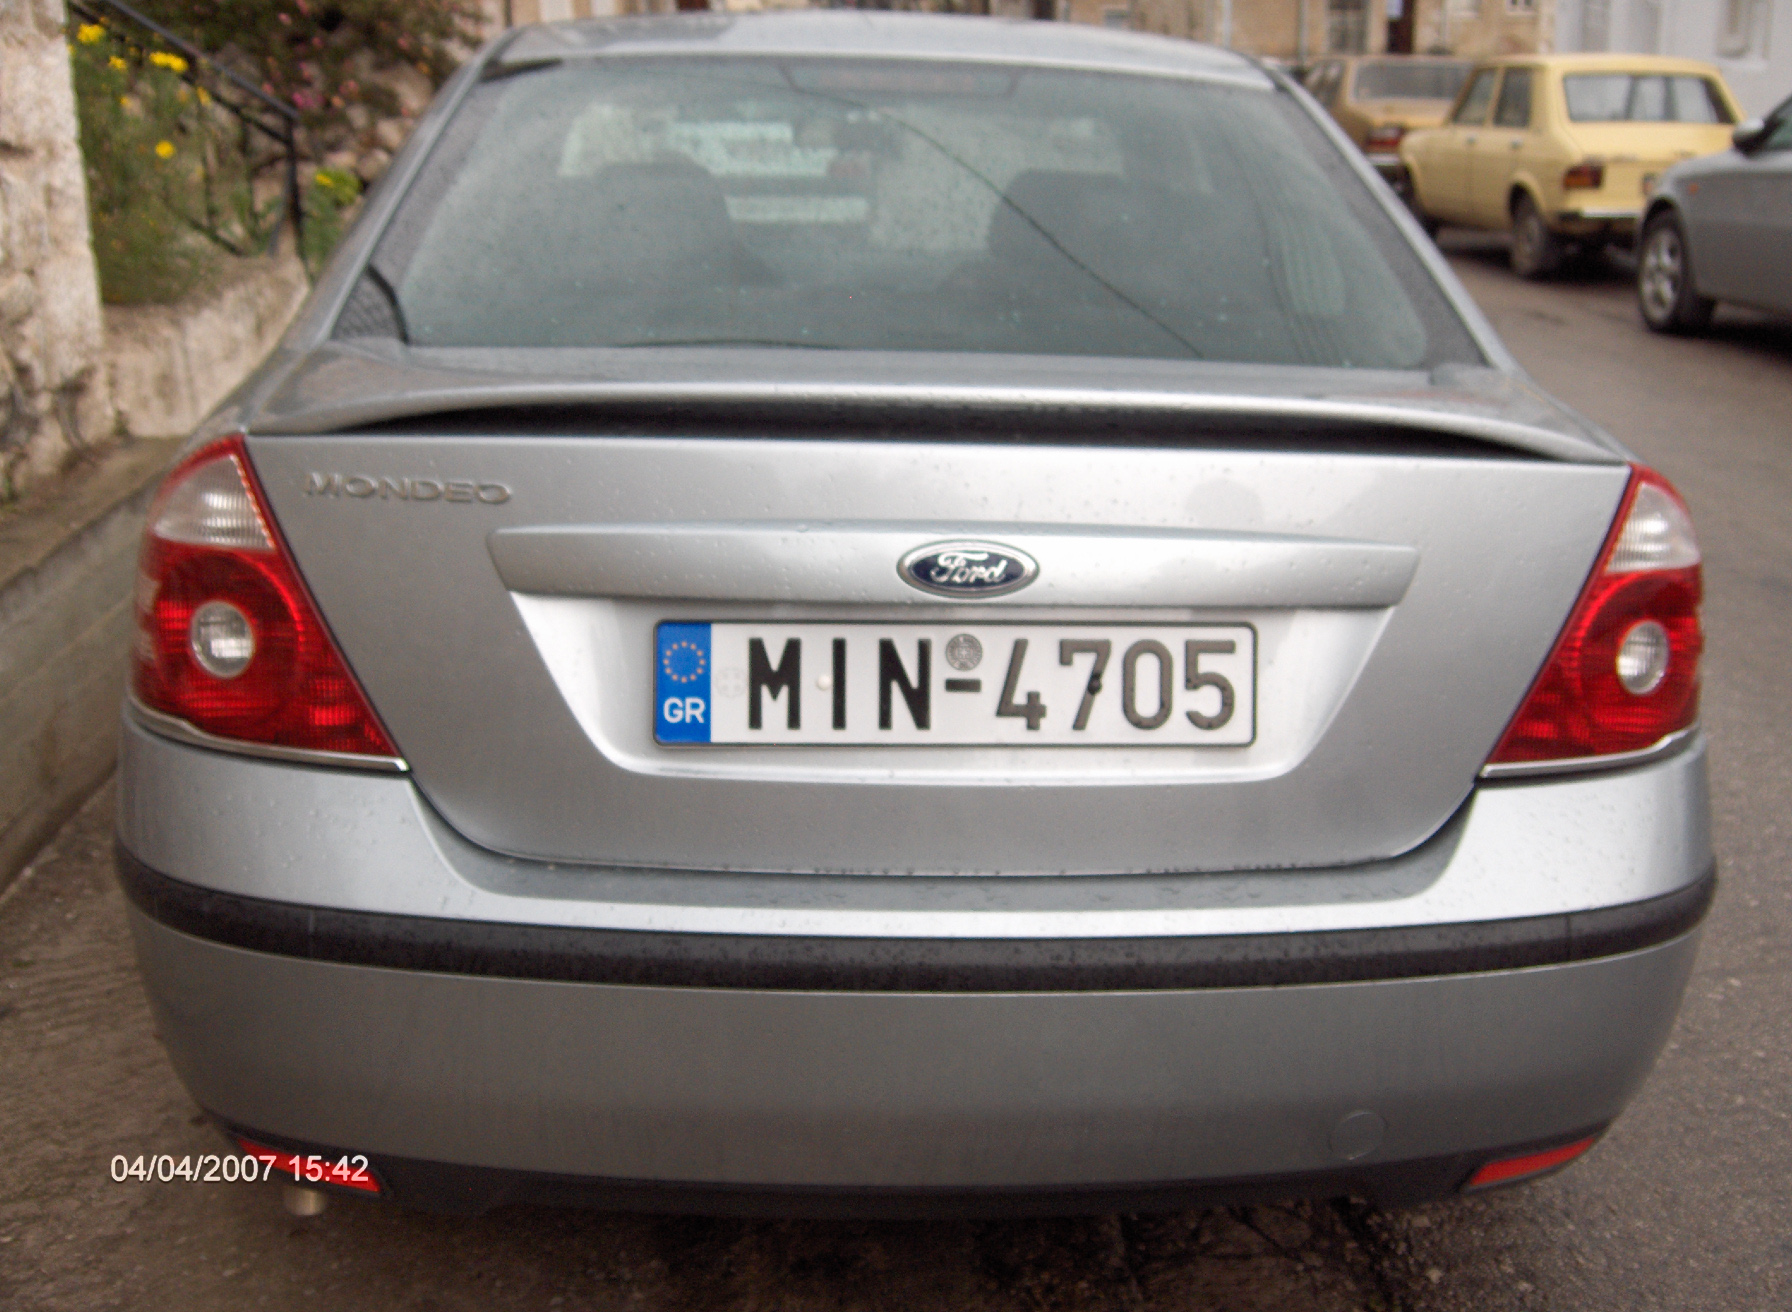

In [2]:
Image("HPIM0711.JPG")

YINL705

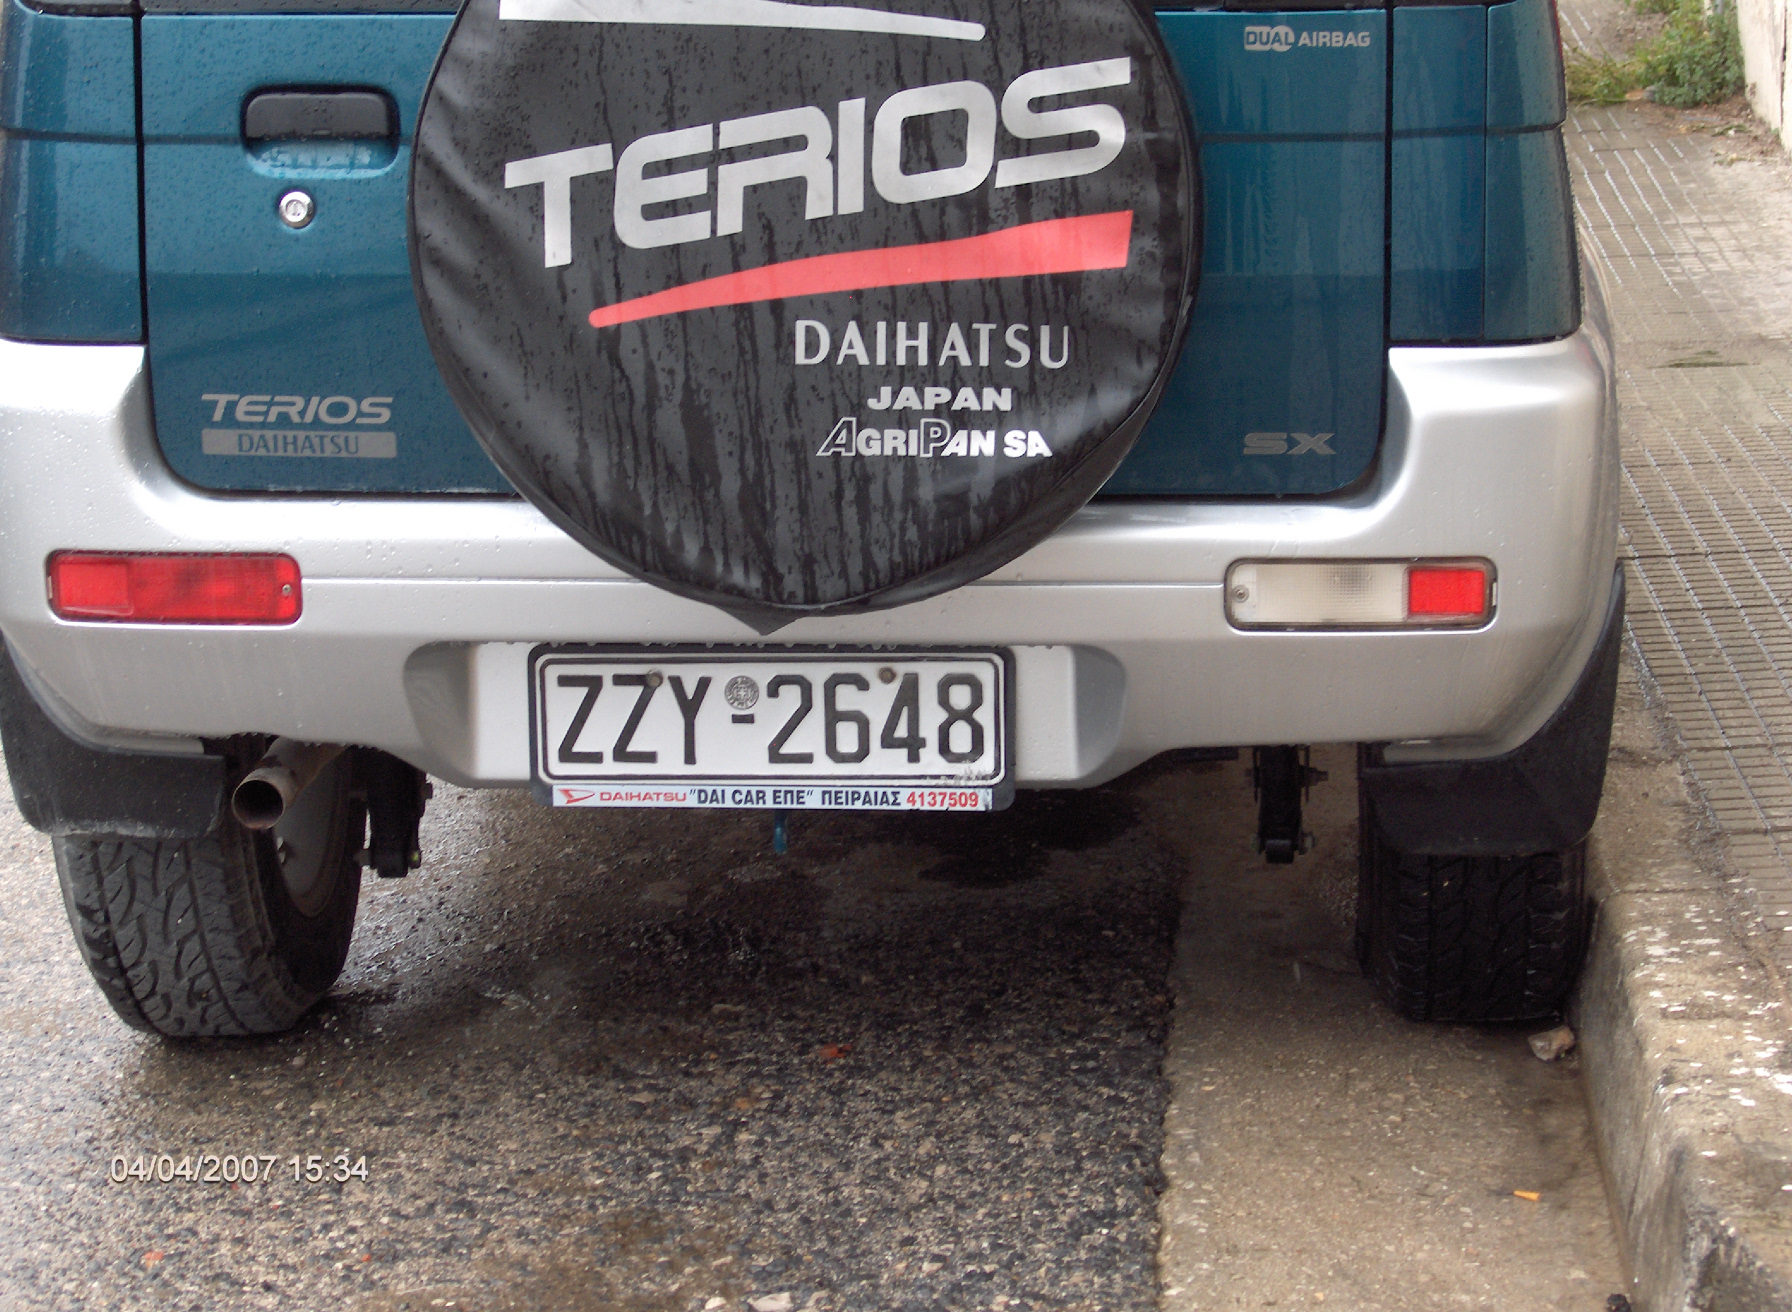

In [3]:
Image("HPIM0686.JPG")

ZZT26R8

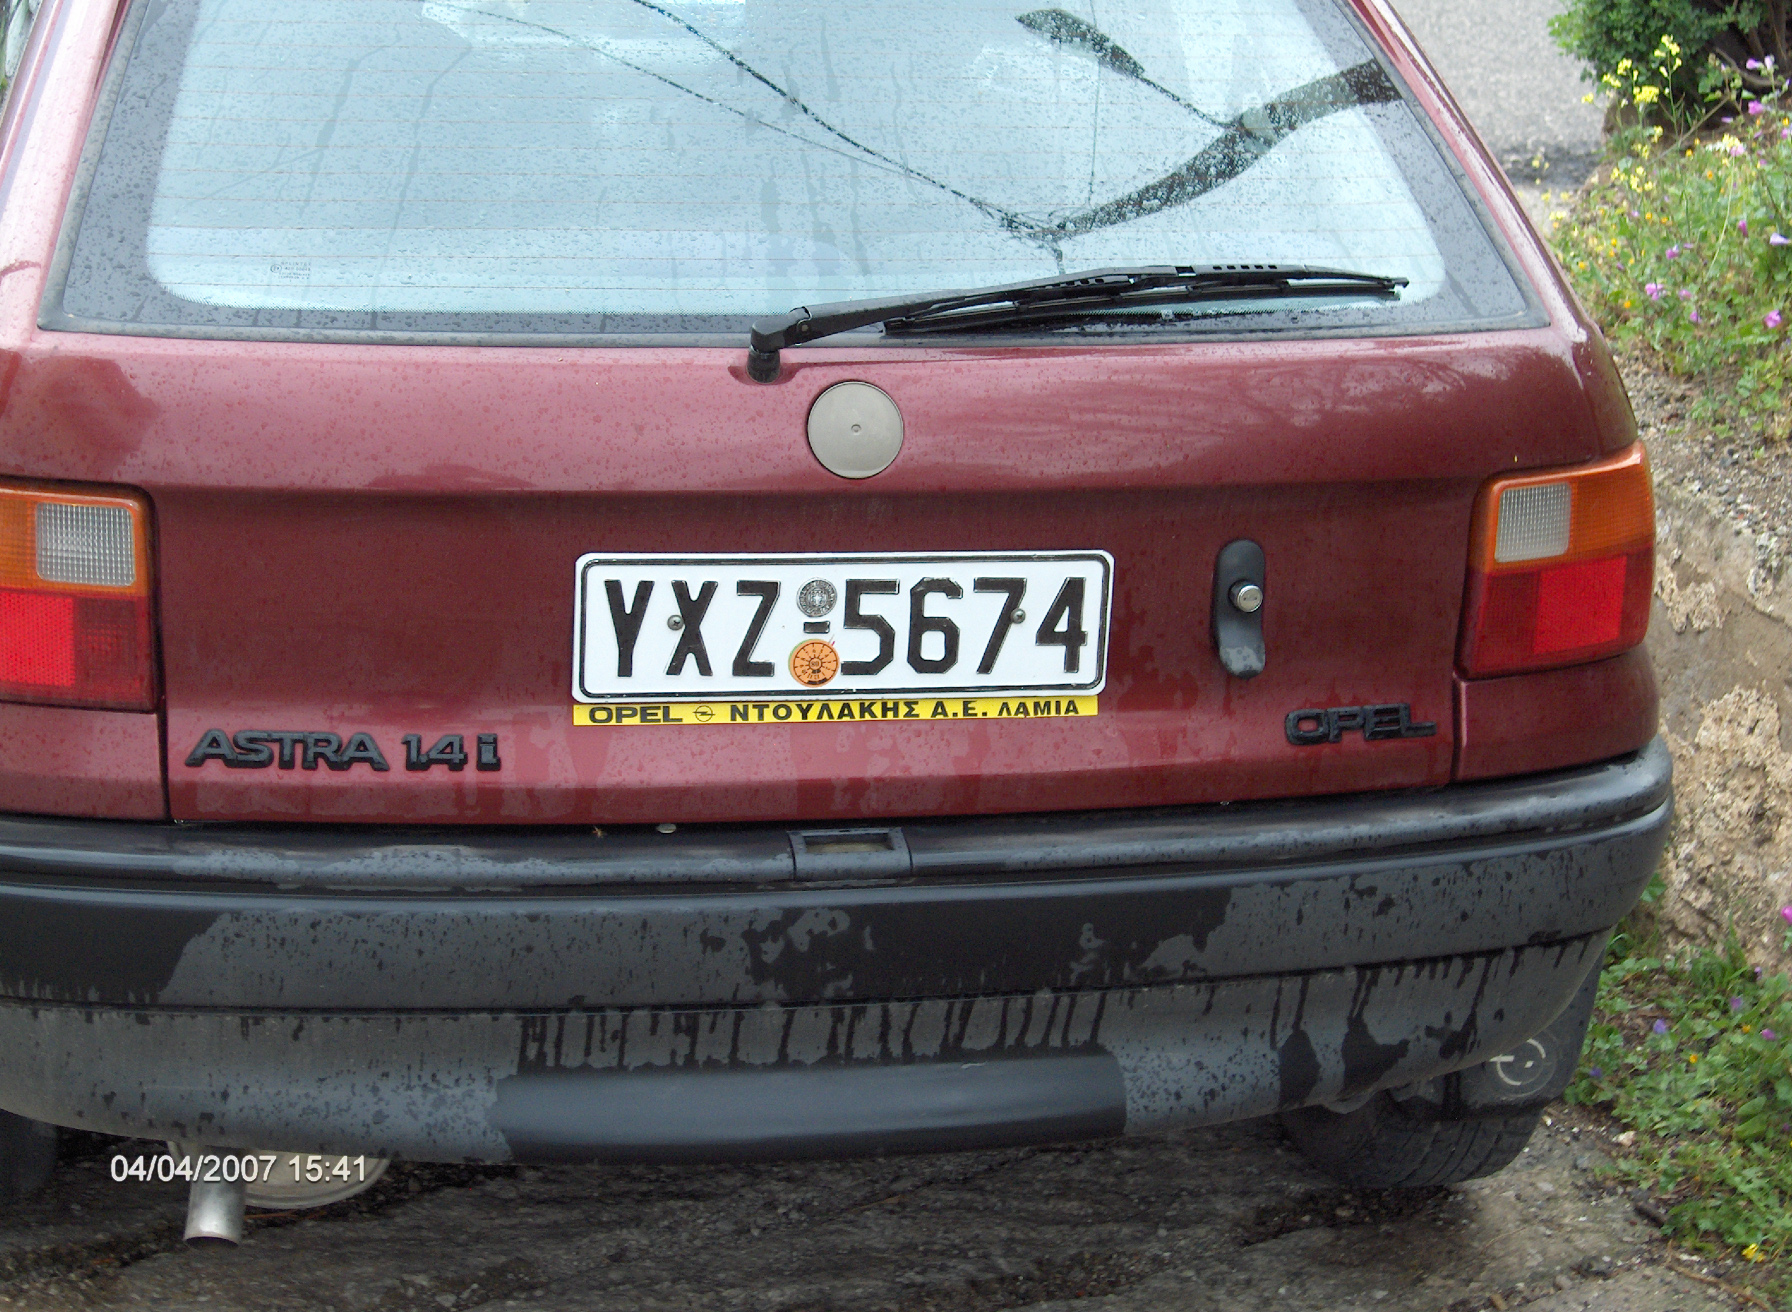

In [4]:
Image("HPIM0707.JPG")

YXZ5674

Example of how to our model to predict plates

In [ ]:
from skimage.io import imread
from LPDetector import LPDetector
import torch
import matplotlib.pyplot as plt
import numpy as np
arr = [0,1,2,3,4,5,6,7,8,9,'A','B' ,'C' ,'D' ,'E' ,'F' , 'G' , 'H' , 'I' , 'J', 'K' , 'L' , 'M' , 'N' , 'O', 'P' , 'Q' , 'R' , 'S' , 'T' , 'U' , 'V' , 'W' , 'X' , 'Y' , 'Z']

originalImg = imread('HPIM0707.JPG')

naber = LPDetector(originalImg)
img_list = naber.solve()


model = torch.load('model.pt')

for i in range(0 , len(img_list)):
	with torch.no_grad():
		y_pred = model(torch.from_numpy(np.array(img_list[i])))
		print(arr[torch.argmax(y_pred)])
